In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ast import literal_eval
import matplotlib.ticker as mtick
from proximity_probabillity_matrix import pair_prev

plt.rcParams.update(plt.rcParamsDefault)
sns.set(context='notebook', rc={'figure.figsize':(14,10)})
PATH = os.getcwd()
%matplotlib inline

In [6]:
# Read the gene groups by phyum csv created using remaking_gene_groups.py
gene_groups = pd.read_csv('gene_groups_post-fix_by_phylum.csv')
gene_groups.Gene_Group = gene_groups.Gene_Group.apply(literal_eval) #Convert col to list
gene_groups.Gene_Group = gene_groups.Gene_Group.apply(lambda x: [i.replace('*', '') for i in x]) #Remove duplicate marks
df = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(PATH)), '01_Database_construction', 'DB_csvs','final.csv'), index_col = 0) #Read final.csv
new_cols = []
for col in gene_groups.columns: #Remove the dumb n indicator from colnames
    if '\n' in col:
        new_cols.append(col.split(' ')[0])
    else:
        new_cols.append(col)
gene_groups.columns = new_cols #Replace the columns
gene_groups_melted = pd.melt(gene_groups, id_vars = 'Gene_Group', var_name = 'Phylum', value_name = 'Prevalence') #Melt into long format
gene_groups_melted = gene_groups_melted[gene_groups_melted.Phylum != 'Prevalence'] #Remove the overall prevalence column
gene_groups.head()

c:\Users\noam1\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Gene_Group,Prevalence,Chordata,Arthropoda,Cnidaria,Echinodermata,Mollusca,Porifera,Platyhelminthes,Nemertea,...,Rotifera,Chaetognatha,Priapulida,Tardigrada,Brachiopoda,Bryozoa,Gastrotricha,Entoprocta,Placozoa,Phoronida
0,"[nad1, trnI, -trnQ, trnM, nad2, trnW, -trnA, -...",43.71,68.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[trnI, -trnQ, trnM, nad2, trnW, -trnA, -trnN, ...",43.71,68.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[-trnQ, trnM, nad2, trnW, -trnA, -trnN, -trnC,...",43.73,68.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[trnM, nad2, trnW, -trnA, -trnN, -trnC, -trnY,...",44.70,69.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[nad2, trnW, -trnA, -trnN, -trnC, -trnY, cox1,...",44.86,69.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
def a_startswith_x(a,x, right):
    """
    Returns True if a starts with x and is the right length

    Parameters
    ----------
    a : str
        The string to check
    x : str
        The string to check against
    right : bool
        True if the string should be the right length, False if it should be the left length
    
    Returns
    -------
    bool
        True if a starts with x and is the right length, False if it doesn't
    """
    mask = (a[1:(len(x)+1)] == x) and (len(a) - 1 == len(x))
    return mask
    
mask = gene_groups_melted.Gene_Group.apply(a_startswith_x, args = [['atp8','atp6'], True])
gene_groups_melted[mask]

,Gene_Group,Phylum,Prevalence
304198,"[trnK, atp8, atp6]",Chordata,99.45
304821,"[trnD, atp8, atp6]",Chordata,0.00
306534,"[cox2, atp8, atp6]",Chordata,0.12
327667,"[nad4L, atp8, atp6]",Chordata,0.00
347800,"[trnW, atp8, atp6]",Chordata,0.04
...,...,...,...
7205483,"[trnS, atp8, atp6]",Phoronida,0.00
7225368,"[trnF, atp8, atp6]",Phoronida,0.00
7272530,"[cox1, atp8, atp6]",Phoronida,0.00
7285286,"[trnP, atp8, atp6]",Phoronida,0.00


In [8]:
interesting = [['nad4L', 'nad4'], ['-nad4', '-nad4L'], ['atp8','atp6']] # Interesting gene pairs
interesting_df = gene_groups_melted[gene_groups_melted['Gene_Group'].isin(interesting)] # Filter to interesting pairs
interesting_df = interesting_df[interesting_df['Phylum'].isin(['Chordata', 'Arthropoda', 'Mollusca', 'Echinodermata', 'Nematoda', 'Cnidaria'])] # Filter to interesting phyla
interesting_df.Gene_Group = [', '.join(i) for i in interesting_df.Gene_Group] # Convert lists to string

In [9]:
interesting_df = interesting_df.groupby(['Gene_Group', 'Phylum']).max().reset_index() # Group by gene group and phylum and get max prevalence for each phylum gene pair combination
display(interesting_df)

,Gene_Group,Phylum,Prevalence
0,"-nad4, -nad4L",Arthropoda,98.13
1,"-nad4, -nad4L",Chordata,0.08
2,"-nad4, -nad4L",Cnidaria,0.00
3,"-nad4, -nad4L",Echinodermata,0.00
4,"-nad4, -nad4L",Mollusca,26.71
5,"-nad4, -nad4L",Nematoda,3.41
6,"atp8, atp6",Arthropoda,98.96
7,"atp8, atp6",Chordata,99.65
8,"atp8, atp6",Cnidaria,29.10
9,"atp8, atp6",Echinodermata,96.10


C:\Users\noam1\AppData\Local\Temp/ipykernel_24860/3388880049.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 13, ha = 'right') # Rotate the x labels


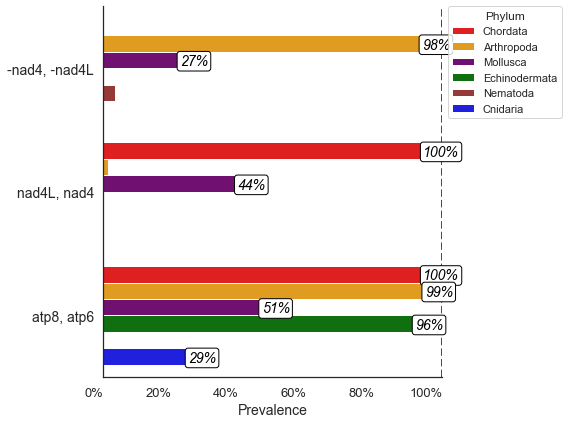

In [10]:
sns.set_style("white")

_, ax = plt.subplots(figsize = (8,6))
y_axis_order = ['-nad4, -nad4L', 'nad4L, nad4', 'atp8, atp6']
# Switch to classic theme 
sns.barplot(x = 'Prevalence', y = 'Gene_Group', hue = 'Phylum', data = interesting_df.sort_values(by = 'Gene_Group'), palette = ['Red', 'Orange', 'Purple', 'Green', 'Brown', 'Blue'], hue_order = ['Chordata', 'Arthropoda', 'Mollusca', 'Echinodermata', 'Nematoda', 'Cnidaria'], order = y_axis_order, ax = ax)
ax.axvline(x = 100, color = 'black', linestyle = '--', alpha = .7, linewidth = 2) # Add a line at 100%
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 13, ha = 'right') # Rotate the x labels
ax.xaxis.set_major_formatter(mtick.PercentFormatter()) # Set the x axis to be a percentage
ax.set_ylabel('') # Remove the y label
sns.despine()
# Add labels to the bars
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0][1]
    y = p.get_bbox().get_points()[1,1]
    if x > 10:
        ax.annotate('{:.0f}%'.format(x), (x , y), ha = 'center', va = 'bottom', fontsize = 14, color = 'black', fontstyle = 'oblique', bbox=dict(boxstyle="round,pad=.2", fc="w", edgecolor = 'black', alpha = 1))
ax.set_xlabel('Prevalence', fontsize = 14) # Set the x label
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 14) # Rotate the y labels
# Reorder y axis
ax.set_xlim((0,100)) # Set the x axis limits
ax.legend(bbox_to_anchor =(1, 1.015), title = 'Phylum') # Set the legend
plt.tight_layout()
plt.savefig(os.path.join('figures', 'fig_3c_interesting_clusters_graph_and_same_strand_matrix.svg'), dpi = 300)